### Imports

In [1]:
from functions.load_data import load_CIFAR_data, load_SVHN_data, load_MNIST_data, shuffle_data
from functions.attacks import attackTestSetBatch
from custom_layers.initializers import BimodalNormalInitializer
#from functions.models import simple_conv_trop_model, simple_conv_relu_model, simple_3layer_conv_relu_model, simple_conv_relu_then_trop_model, simple_3layer_conv_relu_model_with_trop_logits
from functions.tests import test_pdg_steps
from tensorflow.keras import losses, initializers
import numpy as np
from tensorflow.keras.utils import plot_model
from custom_layers.tropical_layers import TropConv2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Conv2D
from tensorflow.keras.models import load_model
import csv
import os
from pathlib import Path

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  # Modify this path to your Graphviz installation directory

In [7]:
result_addition_zero.shape

TensorShape([200, 5, 200])

### LOAD DATA

In [2]:
# -- load MNIST data -- 
x_train, x_test, y_train, y_test = load_MNIST_data(desired_classes=[i for i in range(10)])
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
print(y_train.shape)

(60000, 10)


In [6]:
from functions.models import trop_conv3layer_manyAverageLogits

trop_model = trop_conv3layer_manyAverageLogits(x_train, y_train, batch_size = 64, p=10, num_neurons_b4_logits = 64, initializer_w=BimodalNormalInitializer(1, 0, 0), lam = 0.01)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, 576)          55744       ['input_4[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           36928       ['sequential_6[0][0]']           
                                                                                                  
 class_0 (TropEmbedMaxMin)      (None, 10)           650         ['dense[0][0]']                  
                                                                                            

In [5]:
from functions.models import trop_conv3layer_logits

lammy = [0, 0.1, 1, 10, 100]
for lam in lammy:
    trop_model = trop_conv3layer_logits(x_train, y_train, batch_size = 64, num_neurons_b4_logits = 64, initializer_w=BimodalNormalInitializer(1, 0, 0), lam = lam)

    trop_model.evaluate(x_test, y_test)
    file_path = f'output_data/lam_test/MNIST_trop_{lam}.csv'

    test_pdg_steps(file_path, x_test, y_test, 
                min_steps = 1, max_steps = 41, step_size = 2, eps=0.1, 
                trop_model=trop_model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 576)               55744     
                                                                 
 dense (Dense)               (None, 64)                36928     
                                                                 
 trop_embed_max_min_logits_1  (None, 10)               650       
  (TropEmbedMaxMinLogits)                                        
                                                                 
Total params: 93,322
Trainable params: 93,322
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 [==============================] - 33s 33ms/step - loss: 0.7094 - accuracy: 0.9029
Epoch 2/10
938

In [7]:
from functions.models import relu_conv3layer


relu_model = relu_conv3layer(x_train, y_train, batch_size = 64, num_neurons_b4_logits = 64)

relu_model.evaluate(x_test, y_test)
file_path = f'output_data/lam_test/MNIST_relu.csv'

test_pdg_steps(file_path, x_test, y_test, 
            min_steps = 1, max_steps = 41, step_size = 2, eps=0.1, 
            relu_model=relu_model)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_7 (Sequential)   (None, 576)               55744     
                                                                 
 dense (Dense)               (None, 64)                36928     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 93,322
Trainable params: 93,322
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 [==============================] - 21s 22ms/step - loss: 0.1570 - accuracy: 0.9522
Epoch 2/10
938/938 [==============================] - 25s 27ms/step - loss: 0.04

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras import models

# Assuming 'partial_model' and 'x_train' are available as mentioned earlier.

for i in range(10):
    class_data = x_train[(np.argmax(y_train, axis=1) == i)]
    inputs_class_0 = class_data[:100]
    layer_name = 'dense'  # Replace with the actual name of the desired layer
    partial_model = models.Model(inputs=trop_model.input, outputs=trop_model.get_layer(layer_name).output)
    outputs_class_0 = partial_model.predict(inputs_class_0)
    df_outputs = pd.DataFrame(outputs_class_0)
    df_outputs.to_csv(f'outputs_class_{i}.csv', index=False)

layer = trop_model.get_layer('merge_layer')

arrays = [trop_model.get_layer(inbound_layer.name).get_weights()[0] for _, inbound_layer in enumerate(layer._inbound_nodes[0].inbound_layers)]
concatenated = np.concatenate([arr.flatten() for arr in arrays])
df = pd.DataFrame(concatenated.reshape(-1, 3))
df.to_csv('last_custom_layer_weights.csv', index=False, header=False)

arrays = [trop_model.get_layer(inbound_layer.name).get_weights()[1] for _, inbound_layer in enumerate(layer._inbound_nodes[0].inbound_layers)]
concatenated = np.concatenate([arr.flatten() for arr in arrays])
df = pd.DataFrame(concatenated.reshape(-1, 1))
df.to_csv('last_custom_layer_biases.csv', index=False, header=False)

'''
# Get layer weights from the last custom layer
last_custom_layer_weights = trop_model.get_layer('trop_embed_max_min_1').get_weights()  
weights_to_save = np.asarray(last_custom_layer_weights[0])
np.savetxt('last_custom_layer_weights.csv', weights_to_save, delimiter=',')
weights_to_save = np.asarray(last_custom_layer_weights[1])
np.savetxt('last_custom_layer_biases.csv', weights_to_save, delimiter=',')
'''


4/4 [==============================] - 0s 5ms/step


"\n# Get layer weights from the last custom layer\nlast_custom_layer_weights = trop_model.get_layer('trop_embed_max_min_1').get_weights()  \nweights_to_save = np.asarray(last_custom_layer_weights[0])\nnp.savetxt('last_custom_layer_weights.csv', weights_to_save, delimiter=',')\nweights_to_save = np.asarray(last_custom_layer_weights[1])\nnp.savetxt('last_custom_layer_biases.csv', weights_to_save, delimiter=',')\n"

In [7]:
trop_model.get_layer('trop_embed_max_min_logits').get_weights()[0]

array([[-2.700506  , -2.5961032 ],
       [ 1.9137232 , -4.099133  ],
       [-5.915439  ,  3.2763648 ],
       [ 3.9713607 ,  0.68855673]], dtype=float32)

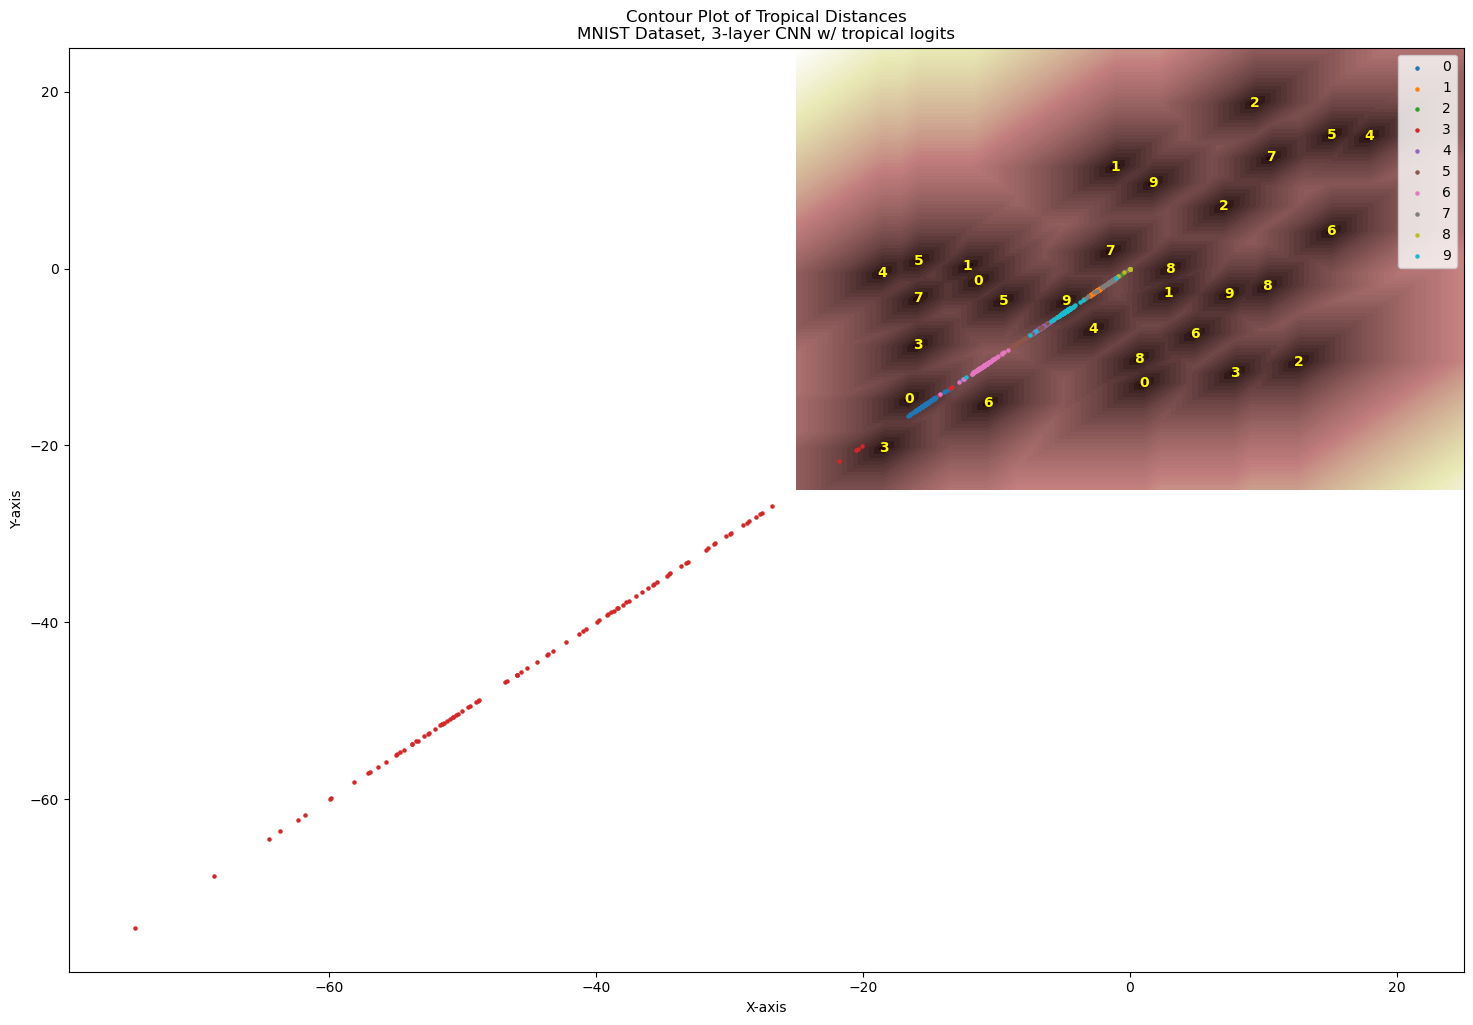

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import pandas as pd

file_start = "C:\\Users\\kurtp\\OneDrive - Naval Postgraduate School\\Desktop\\NPS School Work\\Thesis"
datasets = [pd.read_csv(f"outputs_class_{i}.csv") for i in range(10)]

points = np.genfromtxt('contour_data_10_FW/last_custom_layer_weights.csv', delimiter=',')
biases = np.genfromtxt('contour_data_10_FW/last_custom_layer_biases.csv', delimiter=',')
#print(points.shape, biases.shape)
num_points = points.shape[0]
#print(biases)
# Creating a grid of points
limmy = 25
x = np.linspace(-limmy, limmy, 1000)  # Define the x-axis range
y = np.linspace(-limmy, limmy, 1000)  # Define the y-axis range
X, Y = np.meshgrid(x, y)  # Create a grid of x, y values

# ---- distances to each point in the set of points ----
distances = np.zeros((num_points, X.shape[0], X.shape[1]))
zero_vector = np.zeros((X.shape[0], X.shape[1]))
for i, point in enumerate(points):
    arr0 = X + (point[0] - point[1])
    arr1 = Y + (point[2] - point[1])
    distances[i] = np.maximum(np.maximum(arr0, arr1), zero_vector) - np.minimum(np.minimum(arr0, arr1), zero_vector) + biases[i]

# ---- if we have multiple points per class ----
distances2 = np.zeros((10, 1000, 1000))
p = 3
for i in range(10):
    distances2[i] = np.average(distances[i*p:i*p+p], axis=0)
    #distances2[i] = distances2[i] - np.min(distances2[i])
    #print(np.min(distances2[i]))

# ---- attempt to visualize the decision boundary ----
closest_indices = np.argmin(distances, axis=2)
closest_distances = np.min(distances, axis=2)
sorted_distances = np.sort(distances, axis=2)
second_closest_distances = sorted_distances[:, :, 1]
decision_boundary = np.abs(closest_distances - second_closest_distances)

plt.figure(figsize=(18,12))
plt.contourf(X, Y, decision_boundary, cmap='coolwarm')
plt.colorbar(label='Decision Boundary')

# ---- original ----
#plt.contourf(X, Y, np.min(distances, axis=0), levels=100, cmap='pink')  # Contour plot

i = 0
for df in datasets:
    plt.scatter((df['0']-df['1']), (df['2']-df['1']), label=i, s=5)
    i += 1
class_num = 0
for i, point in enumerate(points):
    if i!= 0 and i % p == 0:
        class_num += 1
    if class_num == 1:
        label_fw = class_num
    else: 
        label_fw = class_num#"-"
    plt.text(-(point[0]-point[1]), -(point[2]-point[1]), label_fw, fontsize=10, ha='center', va='center', weight='bold', color='yellow')
#plt.scatter(points[:, 0], points[:, 1], c='yellow', s=80, edgecolors='black')  # Scatter plot for points
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Contour Plot of Tropical Distances\nMNIST Dataset, 3-layer CNN w/ tropical logits')
plt.show()


In [3]:
file_path = "output_data/MNIST_trop_logits.csv" 
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred', 'model_type'])

step_num = 20
eps = 0.1
num_epochs = 10
for i in range(1):
    print(f'\n\n{i}\n\n')
    # -- Shuffle Data --
    #x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    
    # -- TROPICAL: fit model --
    trop_model = simple_3layer_conv_relu_model_with_trop_logits(x_train=x_train, y_train=y_train, num_epochs=num_epochs)
    
    # -- TROPICAL: attack model -- 
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=step_num)

    # -- TROPICAL: evaluate -- 
    # - before attack -
    pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_trop_preds, y_tester)
    pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

    # - after attack - 
    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'trop']
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

    # -- RELU: fit model --
    relu_model = simple_3layer_conv_relu_model(x_train=x_train, y_train=y_train, num_epochs=num_epochs)

    # -- RELU: attack model -- 
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=step_num)

    # -- RELU: evaluate --
    # - before attack -
    pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_relu_preds, y_tester)
    pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

    # - after attack - 
    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'relu']
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)

np.save('saved_models/trop_x_test_att_trop_logits.npy', trop_x_test_att)
np.save('saved_models/relu_x_test_att_trop_logits.npy', relu_x_test_att)
trop_model.save("saved_models/tropmodel_trop_logits.h5")
relu_model.save("saved_models/relumodel_trop_logits.h5")



0


Epoch 1/10
938/938 [==============================] - 90s 92ms/step - loss: 1.3594 - accuracy: 0.8418
Epoch 2/10
938/938 [==============================] - 104s 111ms/step - loss: 0.3903 - accuracy: 0.9751
Epoch 3/10
938/938 [==============================] - 90s 96ms/step - loss: 0.1842 - accuracy: 0.9823
Epoch 4/10
938/938 [==============================] - 102s 108ms/step - loss: 0.1138 - accuracy: 0.9854
Epoch 5/10
938/938 [==============================] - 96s 103ms/step - loss: 0.0806 - accuracy: 0.9873
Epoch 6/10
938/938 [==============================] - 100s 107ms/step - loss: 0.0624 - accuracy: 0.9883
Epoch 7/10
938/938 [==============================] - 102s 108ms/step - loss: 0.0501 - accuracy: 0.9904
Epoch 8/10
938/938 [==============================] - 91s 97ms/step - loss: 0.0420 - accuracy: 0.9910
Epoch 9/10
938/938 [==============================] - 80s 86ms/step - loss: 0.0362 - accuracy: 0.9918
Epoch 10/10
938/938 [==============================] - 84s 90ms/ste

In [3]:
from custom_layers.tropical_layers import TropEmbedMaxMinLogits

trop_model = load_model("saved_models/tropmodel_trop_logits.h5", custom_objects={'TropEmbedMaxMinLogits':TropEmbedMaxMinLogits})
relu_model = load_model("saved_models/relumodel_trop_logits.h5")
file_path = 'output_data/MNIST_conv3layer_tropLogits_attacks.csv'

test_pdg_steps(file_path, x_test, y_test, 
               min_steps = 1, max_steps = 51, step_size = 2, eps=0.1, 
               trop_model=trop_model, relu_model=relu_model)



1


Tropical model 0% attacked.
Tropical model 8% attacked.
Tropical model 16% attacked.
Tropical model 24% attacked.
Tropical model 32% attacked.
Tropical model 40% attacked.
Tropical model 48% attacked.
Tropical model 56% attacked.
Tropical model 64% attacked.
Tropical model 72% attacked.
Tropical model 80% attacked.
Tropical model 88% attacked.
Tropical model 96% attacked.
Tropical attack complete. Elapsed time: 20.91 seconds | 0.35 minutes.
313/313 [==============================] - 1s 4ms/step - loss: 0.0743 - accuracy: 0.9792


3


Tropical model 0% attacked.
Tropical model 8% attacked.
Tropical model 16% attacked.
Tropical model 24% attacked.
Tropical model 32% attacked.
Tropical model 40% attacked.
Tropical model 48% attacked.
Tropical model 56% attacked.
Tropical model 64% attacked.
Tropical model 72% attacked.
Tropical model 80% attacked.
Tropical model 88% attacked.
Tropical model 96% attacked.
Tropical attack complete. Elapsed time: 37.98 seconds | 0.63 minutes.
313/313 [

### TROPICAL: Basic 3 convolutional layers model

In [ ]:
file_path = "output_data/MNIST_relu_conv_results_30step.csv"  # Replace with the file path you want to check
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred'])

for i in range(30):
    # -- Shuffle Data --
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    
    # -- TROPICAL: fit model --
    trop_model = simple_conv_trop_model(x_train=x_train, y_train=y_train, num_epochs=10)

    # -- TROPICAL: attack model -- 
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=30)

    # -- TROPICAL: evaluate -- 
    # - before attack -
    pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_trop_preds, y_tester)
    pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

    # - after attack - 
    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

Epoch 1/10
938/938 [==============================] - 74s 77ms/step - loss: 1.2553 - accuracy: 0.6377
Epoch 2/10
938/938 [==============================] - 71s 76ms/step - loss: 0.4297 - accuracy: 0.8699
Epoch 3/10
938/938 [==============================] - 62s 66ms/step - loss: 0.2980 - accuracy: 0.9097
Epoch 4/10
938/938 [==============================] - 64s 69ms/step - loss: 0.2515 - accuracy: 0.9235
Epoch 5/10
938/938 [==============================] - 62s 66ms/step - loss: 0.2119 - accuracy: 0.9353
Epoch 6/10
938/938 [==============================] - 61s 65ms/step - loss: 0.1858 - accuracy: 0.9435
Epoch 7/10
938/938 [==============================] - 54s 57ms/step - loss: 0.1702 - accuracy: 0.9481
Epoch 8/10
938/938 [==============================] - 68s 73ms/step - loss: 0.1510 - accuracy: 0.9544
Epoch 9/10
938/938 [==============================] - 60s 64ms/step - loss: 0.1531 - accuracy: 0.9546
Epoch 10/10
938/938 [==============================] - 70s 75ms/step - loss: 0.140

In [11]:
pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
y_tester = np.argmax(y_test, axis=1)
pre_correct_index = np.equal(pre_trop_preds, y_tester)
pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

for i in range(1,150):
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=i)

    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

313/313 [==============================] - 2s 8ms/step - loss: 0.1517 - accuracy: 0.9581
Tropical model 0% attacked.
Tropical model 40% attacked.
Tropical model 80% attacked.
Tropical attack complete. Elapsed time: 15.75 seconds /// 0.26 minutes.
313/313 [==============================] - 2s 7ms/step - loss: 0.2381 - accuracy: 0.9247
Tropical model 0% attacked.
Tropical model 40% attacked.
Tropical model 80% attacked.
Tropical attack complete. Elapsed time: 29.75 seconds /// 0.50 minutes.
313/313 [==============================] - 2s 8ms/step - loss: 0.3522 - accuracy: 0.8858
Tropical model 0% attacked.
Tropical model 40% attacked.
Tropical model 80% attacked.
Tropical attack complete. Elapsed time: 43.94 seconds /// 0.73 minutes.
313/313 [==============================] - 2s 8ms/step - loss: 0.5012 - accuracy: 0.8339
Tropical model 0% attacked.
Tropical model 40% attacked.
Tropical model 80% attacked.
Tropical attack complete. Elapsed time: 58.64 seconds /// 0.98 minutes.
313/313 [===

KeyboardInterrupt: 

### RELU: Basic 3 convolutional layers model

In [4]:
file_path = "output_data/MNIST_relu_conv_results_30step.csv"  # Replace with the file path you want to check
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred'])

for i in range(30):
    # -- Shuffle Data --
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    
    # -- RELU: fit model --
    relu_model = simple_conv_relu_model(x_train=x_train, y_train=y_train)
    #relu_model = simple_3layer_conv_relu_model(x_train=x_train, y_train=y_train)

    # -- RELU: attack model -- 
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=0.1, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=30)

    # -- RELU: evaluate --
    # - before attack -
    pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_relu_preds, y_tester)
    pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

    # - after attack - 
    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

Epoch 1/10
938/938 [==============================] - 49s 51ms/step - loss: 0.3642 - accuracy: 0.8890
Epoch 2/10
938/938 [==============================] - 62s 66ms/step - loss: 0.1058 - accuracy: 0.9672
Epoch 3/10
938/938 [==============================] - 37s 39ms/step - loss: 0.0750 - accuracy: 0.9770
Epoch 4/10
938/938 [==============================] - 63s 68ms/step - loss: 0.0593 - accuracy: 0.9814
Epoch 5/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0502 - accuracy: 0.9849
Epoch 6/10
938/938 [==============================] - 55s 59ms/step - loss: 0.0442 - accuracy: 0.9860
Epoch 7/10
938/938 [==============================] - 44s 46ms/step - loss: 0.0380 - accuracy: 0.9874
Epoch 8/10
938/938 [==============================] - 33s 35ms/step - loss: 0.0331 - accuracy: 0.9894
Epoch 9/10
938/938 [==============================] - 37s 39ms/step - loss: 0.0275 - accuracy: 0.9910
Epoch 10/10
938/938 [==============================] - 44s 47ms/step - loss: 0.024

In [8]:
pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
y_tester = np.argmax(y_test, axis=1)
pre_correct_index = np.equal(pre_relu_preds, y_tester)
pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

for i in range(1,150):
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=0.1, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=i)

    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred]
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

313/313 [==============================] - 1s 2ms/step - loss: 0.0569 - accuracy: 0.9855
ReLU model 0% attacked.
ReLU model 40% attacked.
ReLU model 80% attacked.
ReLU attack complete. Elapsed time: 5.48 seconds /// 0.09 minutes.
313/313 [==============================] - 1s 2ms/step - loss: 0.2186 - accuracy: 0.9300
ReLU model 0% attacked.
ReLU model 40% attacked.
ReLU model 80% attacked.
ReLU attack complete. Elapsed time: 12.08 seconds /// 0.20 minutes.
313/313 [==============================] - 1s 2ms/step - loss: 0.3501 - accuracy: 0.8845
ReLU model 0% attacked.
ReLU model 40% attacked.
ReLU model 80% attacked.
ReLU attack complete. Elapsed time: 18.10 seconds /// 0.30 minutes.
313/313 [==============================] - 1s 2ms/step - loss: 0.5420 - accuracy: 0.8234
ReLU model 0% attacked.
ReLU model 40% attacked.
ReLU model 80% attacked.
ReLU attack complete. Elapsed time: 23.49 seconds /// 0.39 minutes.
313/313 [==============================] - 1s 2ms/step - loss: 0.8082 - accur

KeyboardInterrupt: 

### 20 step test with both

In [3]:
file_path = "output_data/MNIST_both_conv_results_20step_4.csv" 
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred', 'model_type'])

step_num = 20
eps = 0.1
num_epochs = 20
for i in range(1):
    print(f'\n\n{i}\n\n')
    # -- Shuffle Data --
    #x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    
    # -- TROPICAL: fit model --
    trop_model = simple_conv_trop_model(x_train=x_train, y_train=y_train, num_epochs=num_epochs)
    
    # -- TROPICAL: attack model -- 
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=step_num)

    # -- TROPICAL: evaluate -- 
    # - before attack -
    pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_trop_preds, y_tester)
    pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

    # - after attack - 
    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'trop']
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

    # -- RELU: fit model --
    relu_model = simple_conv_relu_model(x_train=x_train, y_train=y_train, num_epochs=num_epochs)

    # -- RELU: attack model -- 
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=step_num)

    # -- RELU: evaluate --
    # - before attack -
    pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_relu_preds, y_tester)
    pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

    # - after attack - 
    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'relu']
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)

np.save('saved_models/trop_x_test_att.npy', trop_x_test_att)
np.save('saved_models/relu_x_test_att.npy', relu_x_test_att)
trop_model.save("saved_models/tropmodel.h5")
relu_model.save("saved_models/relumodel.h5")



0


Epoch 1/20
938/938 [==============================] - 62s 65ms/step - loss: 1.5452 - accuracy: 0.5865
Epoch 2/20
938/938 [==============================] - 66s 70ms/step - loss: 0.3943 - accuracy: 0.8792
Epoch 3/20
938/938 [==============================] - 70s 74ms/step - loss: 0.2732 - accuracy: 0.9174
Epoch 4/20
938/938 [==============================] - 64s 68ms/step - loss: 0.2215 - accuracy: 0.9335
Epoch 5/20
938/938 [==============================] - 66s 70ms/step - loss: 0.1930 - accuracy: 0.9416
Epoch 6/20
938/938 [==============================] - 68s 73ms/step - loss: 0.1741 - accuracy: 0.9474
Epoch 7/20
938/938 [==============================] - 66s 70ms/step - loss: 0.1621 - accuracy: 0.9515
Epoch 8/20
938/938 [==============================] - 61s 65ms/step - loss: 0.1504 - accuracy: 0.9546
Epoch 9/20
938/938 [==============================] - 61s 65ms/step - loss: 0.1398 - accuracy: 0.9581
Epoch 10/20
938/938 [==============================] - 62s 66ms/step - loss:

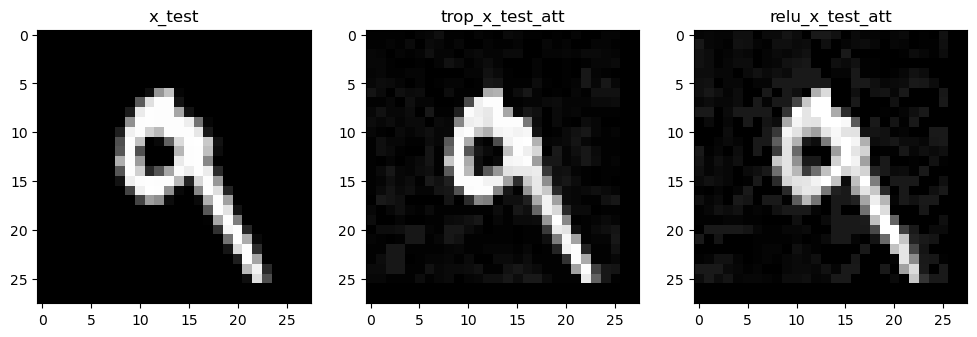

In [12]:
import matplotlib.pyplot as plt
import numpy as np

#trop_x_test_att = np.load('saved_models/trop_x_test_att.npy')
#relu_x_test_att = np.load('saved_models/relu_x_test_att.npy')

# Choose an index for the images you want to display
index = 7

# Get the images
image_x_test = x_test[index].squeeze()  # Remove the single channel dimension (if present)
image_trop_x_test_att = trop_x_test_att[index].squeeze()
image_relu_x_test_att = relu_x_test_att[index].squeeze()

# Create a figure with two subplots
plt.figure(figsize=(12, 5))  # Adjust the figure size as needed
plt.subplot(1, 3, 1)  # One row, two columns, first subplot
plt.imshow(image_x_test, cmap='gray')  # Display the first image
plt.title('x_test')

plt.subplot(1, 3, 2)  # One row, two columns, second subplot
plt.imshow(image_trop_x_test_att, cmap='gray')  # Display the second image
plt.title('trop_x_test_att')

plt.subplot(1, 3, 3)  # One row, two columns, second subplot
plt.imshow(image_relu_x_test_att, cmap='gray')  # Display the second image
plt.title('relu_x_test_att')

plt.show()


In [39]:
import tensorflow as tf
from custom_layers.tropical_layers import TropConv2D

# Load the model from the .h5 file
trop_model = tf.keras.models.load_model("saved_models/tropmodel.h5", custom_objects={"TropConv2D": TropConv2D})
relu_model = tf.keras.models.load_model("saved_models/relumodel.h5")


In [7]:
t_data = trop_model.get_weights()[0].flatten()
r_data = relu_model.get_weights()[0].flatten()

In [33]:
len(trop_model.get_weights())

6

In [25]:
t_bias_data = trop_model.get_weights()[1]
t_data = trop_model.get_weights()[0]

In [30]:
trop_model.get_layer('trop_conv2d').set_weights([t_data*50, t_bias_data*50])

In [31]:
trop_model.evaluate(x_test, y_test)
trop_model.evaluate(trop_x_test_att, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 89.8256 - accuracy: 0.1227


[89.8255844116211, 0.12269999831914902]

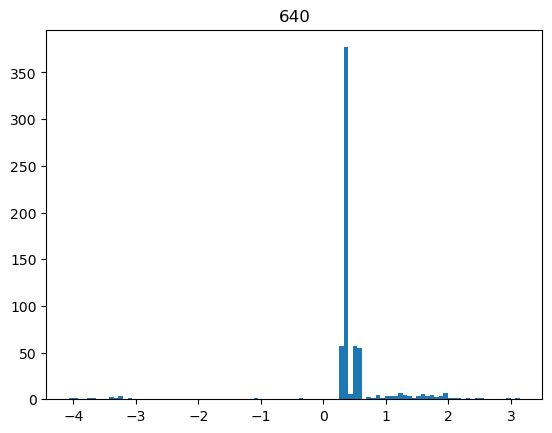

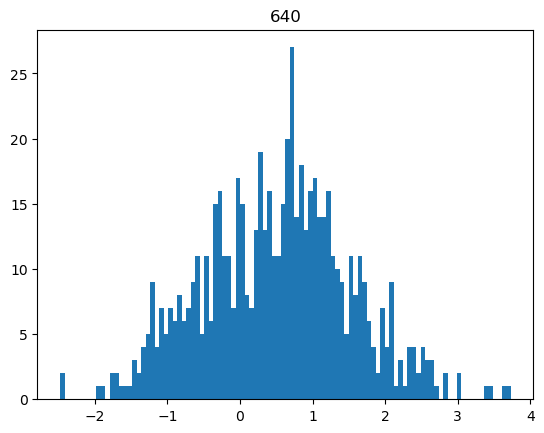

In [17]:
import matplotlib.pyplot as plt

t_data = trop_model.get_weights()[-2].flatten()
plt.hist(t_data, bins=100)
plt.title(len(t_data))
plt.show()

r_data = relu_model.get_weights()[-2].flatten()
plt.hist(r_data, bins=100)
plt.title(len(r_data))
plt.show()

### Adjusting first filter size

In [3]:
file_path = "output_data/MNIST_both_conv_results_filter_adjust.csv"  # Replace with the file path you want to check
if not Path(file_path).is_file():
    with open(file_path, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred', 'model_type', 'num_filter'])

step_num = 20
eps = 0.1
list_filter = [1, 2, 4, 8, 16, 32, 64]
for _ in range(5):
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    for i in list_filter:
        print(f'\n\n{i}\n\n')
        # -- Shuffle Data --
        
        
        # -- TROPICAL: fit model --
        trop_model = simple_conv_trop_model(x_train=x_train, y_train=y_train, num_first_filters = i, num_epochs=10)

        # -- TROPICAL: attack model -- 
        trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=step_num)

        # -- TROPICAL: evaluate -- 
        # - before attack -
        pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
        y_tester = np.argmax(y_test, axis=1)
        pre_correct_index = np.equal(pre_trop_preds, y_tester)
        pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

        # - after attack - 
        post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
        post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

        # - number maintaining prediction - 
        maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

        data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'trop', i]
        with open(file_path, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(data)

        # -- RELU: fit model --
        relu_model = simple_conv_relu_model(x_train=x_train, y_train=y_train, num_first_filters = i)
        #relu_model = simple_3layer_conv_relu_model(x_train=x_train, y_train=y_train)

        # -- RELU: attack model -- 
        relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=step_num)

        # -- RELU: evaluate --
        # - before attack -
        pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
        y_tester = np.argmax(y_test, axis=1)
        pre_correct_index = np.equal(pre_relu_preds, y_tester)
        pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

        # - after attack - 
        post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
        post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

        # - number maintaining prediction - 
        maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

        data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'relu', i]
        with open(file_path, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(data)




1


Epoch 1/10
938/938 [==============================] - 42s 41ms/step - loss: 1.4660 - accuracy: 0.7081
Epoch 2/10
938/938 [==============================] - 42s 44ms/step - loss: 0.3527 - accuracy: 0.8936
Epoch 3/10
938/938 [==============================] - 38s 41ms/step - loss: 0.2467 - accuracy: 0.9254
Epoch 4/10
938/938 [==============================] - 38s 40ms/step - loss: 0.1899 - accuracy: 0.9422
Epoch 5/10
938/938 [==============================] - 38s 40ms/step - loss: 0.1551 - accuracy: 0.9524
Epoch 6/10
938/938 [==============================] - 38s 40ms/step - loss: 0.1304 - accuracy: 0.9594
Epoch 7/10
938/938 [==============================] - 41s 43ms/step - loss: 0.1133 - accuracy: 0.9657
Epoch 8/10
938/938 [==============================] - 41s 44ms/step - loss: 0.0992 - accuracy: 0.9688
Epoch 9/10
938/938 [==============================] - 40s 43ms/step - loss: 0.0911 - accuracy: 0.9719
Epoch 10/10
938/938 [==============================] - 39s 41ms/step - loss:

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.hist(trop_model.layers[0].get_weights().flatten())
plt.show()

ValueError: x must have 2 or fewer dimensions

: 

### VISUALIZATIONS: Showing structure of models used above.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (32, 26, 26, 32)          320       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 13, 13, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (32, 11, 11, 32)          9248      
                                                                 
 flatten_3 (Flatten)         (32, 3872)                0         
                                                                 
 dense_3 (Dense)             (32, 10)                  38730     
                                                                 
Total params: 48,298
Trainable params: 48,298
Non-trainable params: 0
__________________________________________________

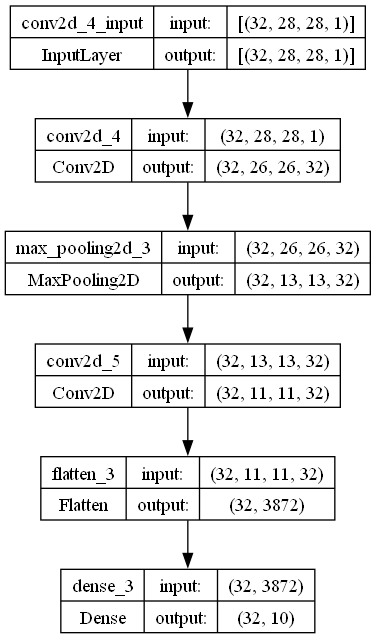

In [5]:
initializer_relu = initializers.random_normal
final_layer_activation = 'softmax'
training_loss = 'categorical_crossentropy'
input_shape = (28, 28, 1)
model = Sequential([Conv2D(32, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),                            
                    Conv2D(32, (3, 3), activation='relu'),
                    Flatten(),
                    Dense(10, activation=final_layer_activation, kernel_initializer = initializer_relu)])
model.build(input_shape=(32, 28, 28, 1))
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 trop_conv2d (TropConv2D)    (32, 26, 26, 32)          320       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 13, 13, 32)         0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (32, 11, 11, 32)          9248      
                                                                 
 flatten (Flatten)           (32, 3872)                0         
                                                                 
 dense (Dense)               (32, 10)                  38730     
                                                                 
Total params: 48,298
Trainable params: 48,298
Non-trainable params: 0
____________________________________________________

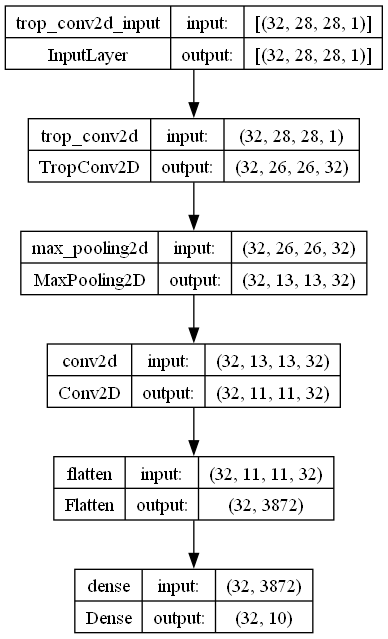

In [2]:
initializer_trop = initializers.random_normal
initializer_relu = initializers.random_normal

model = Sequential([TropConv2D(filters=32),
                    MaxPooling2D((2, 2)),                            
                    Conv2D(32, (3, 3), activation='relu'),
                    Flatten(),
                    Dense(10, activation='softmax', kernel_initializer = initializer_relu)])
model.build(input_shape=(32, 28, 28, 1))
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### RESULTS: Degradation of prediction power from PGD attack

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

full_data = pd.read_csv('MNIST_conv3layer_trop_logies_attacks.csv')
relu_data = full_data[full_data['model_type'] == 'relu']
trop_data = full_data[full_data['model_type'] == 'trop']

col1 = relu_data['maintained_correct_pred']
col2 = trop_data['maintained_correct_pred']
plt.boxplot([col1, col2], labels=[col1.mean(), col2.mean()])
plt.xticks([1, 2], [f'ReLU, {len(relu_data)} experiments', f'Tropical, {len(trop_data)} experiments'])  # Set x-axis labels
plt.xlabel('Model Type')  # Set the x-axis label
plt.ylabel('Portion of Correctly Predicted Labels Maintained')  # Set the y-axis label
plt.title(f'Portion of Correctly Predicted Labels Maintained\nAfter PGD attack on Test Set\n\nReLU mean={round(col1.mean(),3)}---ReLU std={round(col1.std(),3)}\nTrop mean={round(col2.mean(),3)}---Trop std={round(col2.std(),3)}')  # Set the title
plt.show()

col1 = relu_data['pre_acc']
col2 = trop_data['pre_acc']
plt.boxplot([col1, col2], labels=[col1.mean(), col2.mean()])
plt.xticks([1, 2], [f'ReLU, {len(relu_data)} experiments', f'Tropical, {len(trop_data)} experiments'])  # Set x-axis labels
plt.xlabel('Model Type')  # Set the x-axis label
plt.ylabel('Test Set Accuracy')  # Set the y-axis label
plt.title(f'Pre-Attack Test Set Accuracy\n\nReLU mean={round(col1.mean(),3)}---ReLU std={round(col1.std(),3)}\nTrop mean={round(col2.mean(),3)}---Trop std={round(col2.std(),3)}')  # Set the title
plt.show()

rx = relu_data['num_filter']
ry1 = relu_data['pre_acc']
ry2 = relu_data['maintained_correct_pred']
tx = trop_data['num_filter']
ty1 = trop_data['pre_acc']
ty2 = trop_data['maintained_correct_pred']
plt.scatter(rx, ry1, color='orange', label='ReLU - pre_acc')
plt.scatter(rx, ry2, color='red', label='ReLU - maintained_correct_pred')
plt.scatter(tx, ty1, color='blue', label='Tropical - pre_acc')
plt.scatter(tx, ty2, color='purple', label='Tropical - maintained_correct_pred')
plt.legend()
plt.title('Testing adjustment of number of kernels in first layer')
plt.xlabel('Number of kernels')
plt.ylabel('Accuracy')
plt.xlim(0, 32)
plt.show()


ModuleNotFoundError: No module named 'pandas'

In [40]:
file_path_trop = 'output_data/MNIST_trop_conv_pgd_step_test.csv'  # Replace with the file path you want to check
file_path_relu = 'output_data/MNIST_relu_conv_pgd_step_test.csv'
'''with open(file_path_trop, 'a', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred', 'model_type', 'num_steps'])

with open(file_path_relu, 'a', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['pre_loss', 'pre_acc', 'post_loss', 'post_acc', 'maintained_correct_pred', 'model_type', 'num_steps'])
'''
step_num = 20
eps = 0.1
list_steps = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
list_steps = [11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
for i in list_steps:
    print(f'\n\n{i}\n\n')
    # -- TROPICAL: attack model -- 
    trop_x_test_att = attackTestSetBatch(trop_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(),modelName='Tropical', num_steps=i)

    # -- TROPICAL: evaluate -- 
    # - before attack -
    pre_trop_preds = np.argmax(trop_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_trop_preds, y_tester)
    pre_loss, pre_acc = trop_model.evaluate(x_test, y_test)

    # - after attack - 
    post_trop_preds = np.argmax(trop_model.predict(trop_x_test_att), axis=1)
    post_loss, post_acc = trop_model.evaluate(trop_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_trop_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'trop', i]
    with open(file_path_trop, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

    # -- RELU: attack model -- 
    relu_x_test_att = attackTestSetBatch(relu_model, x_test, y_test,  epsilon=eps, loss_object=losses.CategoricalCrossentropy(), modelName='ReLU', num_steps=i)

    # -- RELU: evaluate --
    # - before attack -
    pre_relu_preds = np.argmax(relu_model.predict(x_test), axis=1)
    y_tester = np.argmax(y_test, axis=1)
    pre_correct_index = np.equal(pre_relu_preds, y_tester)
    pre_loss, pre_acc = relu_model.evaluate(x_test, y_test)

    # - after attack - 
    post_relu_preds = np.argmax(relu_model.predict(relu_x_test_att), axis=1)
    post_loss, post_acc = relu_model.evaluate(relu_x_test_att, y_test)

    # - number maintaining prediction - 
    maintained_correct_pred = np.average(np.equal(post_relu_preds[pre_correct_index], y_tester[pre_correct_index]))

    data = [pre_loss, pre_acc, post_loss, post_acc, maintained_correct_pred, 'relu', i]
    with open(file_path_relu, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)




1


Tropical model 0% attacked.
Tropical model 8% attacked.
Tropical model 16% attacked.
Tropical model 24% attacked.
Tropical model 32% attacked.
Tropical model 40% attacked.
Tropical model 48% attacked.
Tropical model 56% attacked.
Tropical model 64% attacked.
Tropical model 72% attacked.
Tropical model 80% attacked.
Tropical model 88% attacked.
Tropical model 96% attacked.
Tropical attack complete. Elapsed time: 42.20 seconds | 0.70 minutes.
313/313 [==============================] - 3s 11ms/step - loss: 0.1869 - accuracy: 0.9412
ReLU model 0% attacked.
ReLU model 8% attacked.
ReLU model 16% attacked.
ReLU model 24% attacked.
ReLU model 32% attacked.
ReLU model 40% attacked.
ReLU model 48% attacked.
ReLU model 56% attacked.
ReLU model 64% attacked.
ReLU model 72% attacked.
ReLU model 80% attacked.
ReLU model 88% attacked.
ReLU model 96% attacked.
ReLU attack complete. Elapsed time: 12.74 seconds | 0.21 minutes.
313/313 [==============================] - 1s 3ms/step - loss: 0.1303 

KeyboardInterrupt: 

In [5]:
relu_res['pre_acc'].iloc[0]

0.9864000082015992

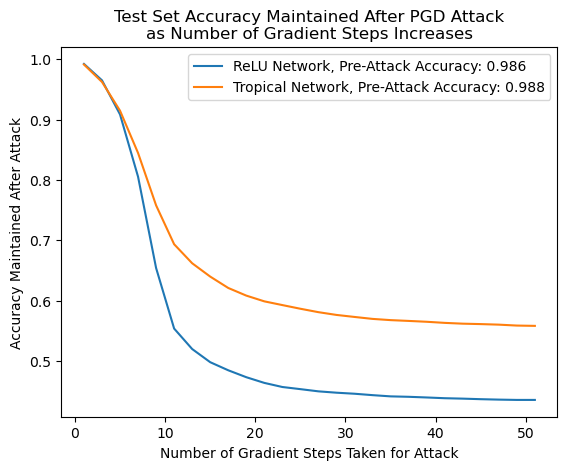

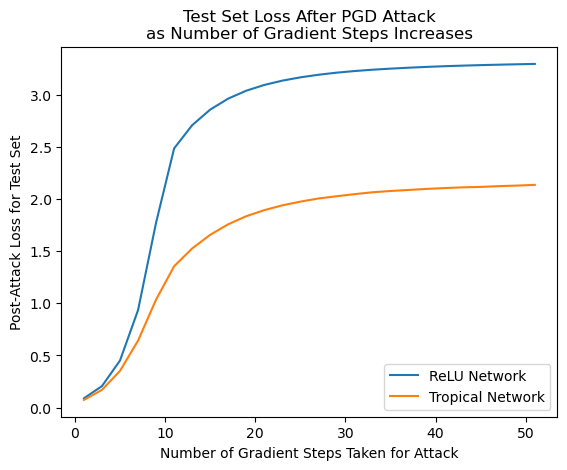

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
#MNIST_conv3layer_manyAvgTropLogits_attacks
#file_path='output_data/MNIST_conv3layer_tropLogits_attacks.csv'
file_path='output_data/MNIST_conv3layer_manyAvgTropLogits_attacks.csv'
all_data = pd.read_csv(file_path)
trop_res = all_data[all_data['model_type']=='trop']
#relu_res = all_data[all_data['model_type']=='relu']
#plt.plot(relu_res['attack'], relu_res['maintained_correct_pred'], label=f"ReLU Network, Pre-Attack Accuracy: {round(relu_res['pre_acc'].iloc[0],3)}")
plt.plot(trop_res['attack'], trop_res['maintained_correct_pred'], label=f"Tropical Network, Pre-Attack Accuracy: {round(trop_res['pre_acc'].iloc[0],3)}")
plt.title('Test Set Accuracy Maintained After PGD Attack\nas Number of Gradient Steps Increases')
plt.xlabel('Number of Gradient Steps Taken for Attack')
plt.ylabel('Accuracy Maintained After Attack')
#plt.xlim((0,40))
plt.legend()
plt.show()

#plt.plot(relu_res['attack'], relu_res['post_loss'], label=f'ReLU Network')
plt.plot(trop_res['attack'], trop_res['post_loss'], label=f'Tropical Network')
plt.title('Test Set Loss After PGD Attack\nas Number of Gradient Steps Increases')
plt.xlabel('Number of Gradient Steps Taken for Attack')
plt.ylabel('Post-Attack Loss for Test Set')
#plt.xlim((0,40))
plt.legend()
plt.show()



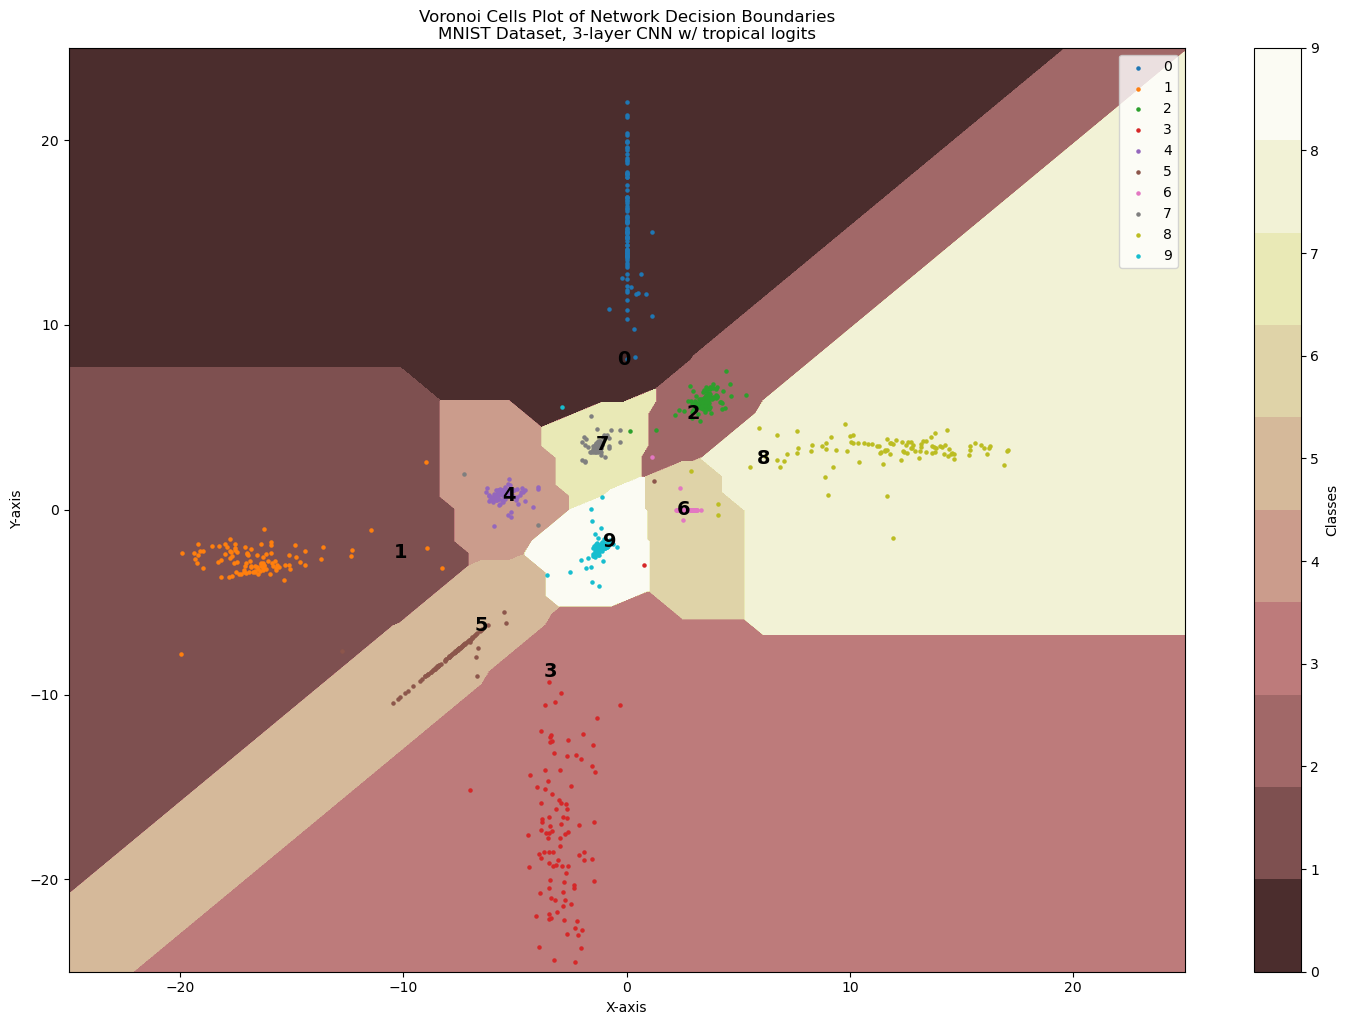

In [6]:
# voronoi diagram plot

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

file_start = "C:\\Users\\kurtp\\OneDrive - Naval Postgraduate School\\Desktop\\NPS School Work\\Thesis"
datasets = [pd.read_csv(f"countour_data_10_FW/outputs_class_{i}.csv") for i in range(10)]

points = np.genfromtxt('countour_data_10_FW/last_custom_layer_weights.csv', delimiter=',')
biases = np.genfromtxt('countour_data_10_FW/last_custom_layer_biases.csv', delimiter=',')
#print(points.shape, biases.shape)
num_points = points.shape[0]
#print(biases)
# Creating a grid of points
limmy = 25
x = np.linspace(-limmy, limmy, 1000)  # Define the x-axis range
y = np.linspace(-limmy, limmy, 1000)  # Define the y-axis range
X, Y = np.meshgrid(x, y)  # Create a grid of x, y values

# ---- distances to each point in the set of points ----
distances = np.zeros((num_points, X.shape[0], X.shape[1]))
zero_vector = np.zeros((X.shape[0], X.shape[1]))
for i, point in enumerate(points):
    arr0 = X + (point[0] - point[1])
    arr1 = Y + (point[2] - point[1])
    distances[i] = np.maximum(np.maximum(arr0, arr1), zero_vector) - np.minimum(np.minimum(arr0, arr1), zero_vector) #+ biases[i]
p = 1
# ---- if we have multiple points per class ----
'''distances2 = np.zeros((10, 1000, 1000))

for i in range(10):
    distances2[i] = np.average(distances[i*p:i*p+p], axis=0)
    #distances2[i] = distances2[i] - np.min(distances2[i])
    #print(np.min(distances2[i]))
'''

num_classes = 10
plt.figure(figsize=(18,12))
plt.contourf(X, Y, np.argmin(distances, axis=0), levels=np.linspace(0, 10-1, 10+1), cmap='pink')
plt.colorbar(ticks=np.arange(num_classes), label='Classes')

#np.linspace(0, 9, 10)
# ---- original ----
#plt.contourf(X, Y, np.min(distances, axis=0), levels=100, cmap='pink')  # Contour plot
#plt.colorbar(label='Tropical Distance')

i = 0
for df in datasets:
    plt.scatter((df['0']-df['1']), (df['2']-df['1']), label=i, s=5)
    i += 1
class_num = 0
for i, point in enumerate(points):
    if i!= 0 and i % p == 0:
        class_num += 1
    if class_num == 1:
        label_fw = class_num
    else: 
        label_fw = class_num#"-"
    plt.text(-(point[0]-point[1]), -(point[2]-point[1]), label_fw, fontsize=14, ha='center', va='center', weight='bold', color='black')
#plt.scatter(points[:, 0], points[:, 1], c='yellow', s=80, edgecolors='black')  # Scatter plot for points
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Voronoi Cells Plot of Network Decision Boundaries\nMNIST Dataset, 3-layer CNN w/ tropical logits')
plt.show()


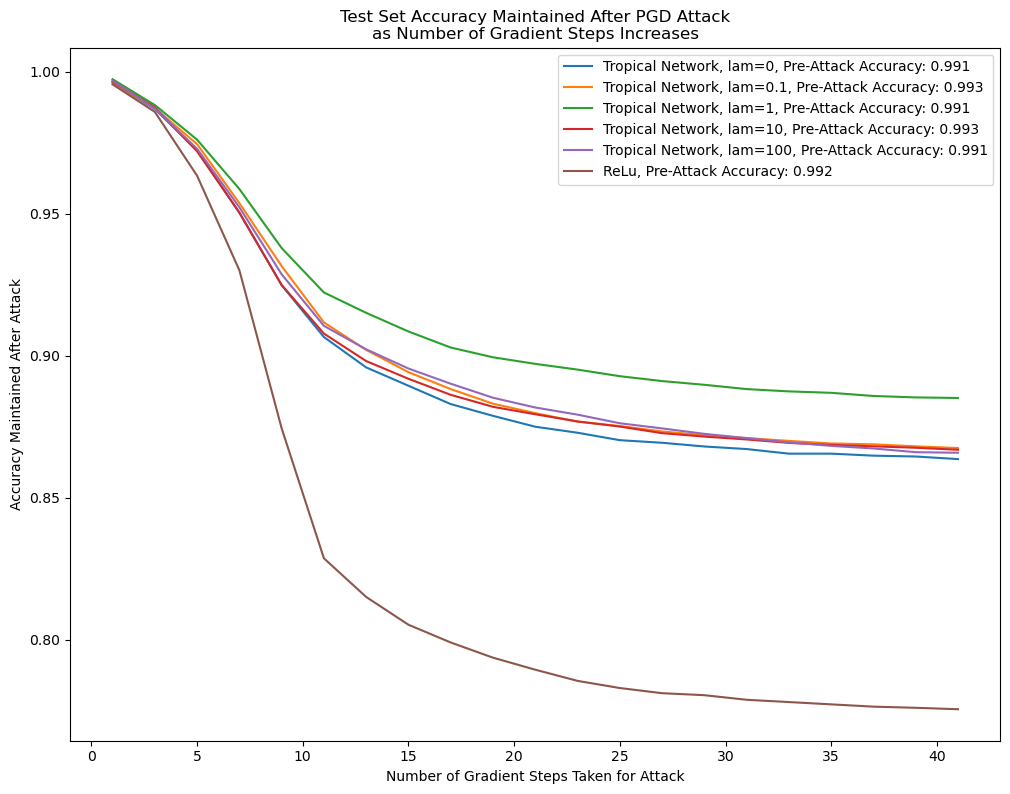

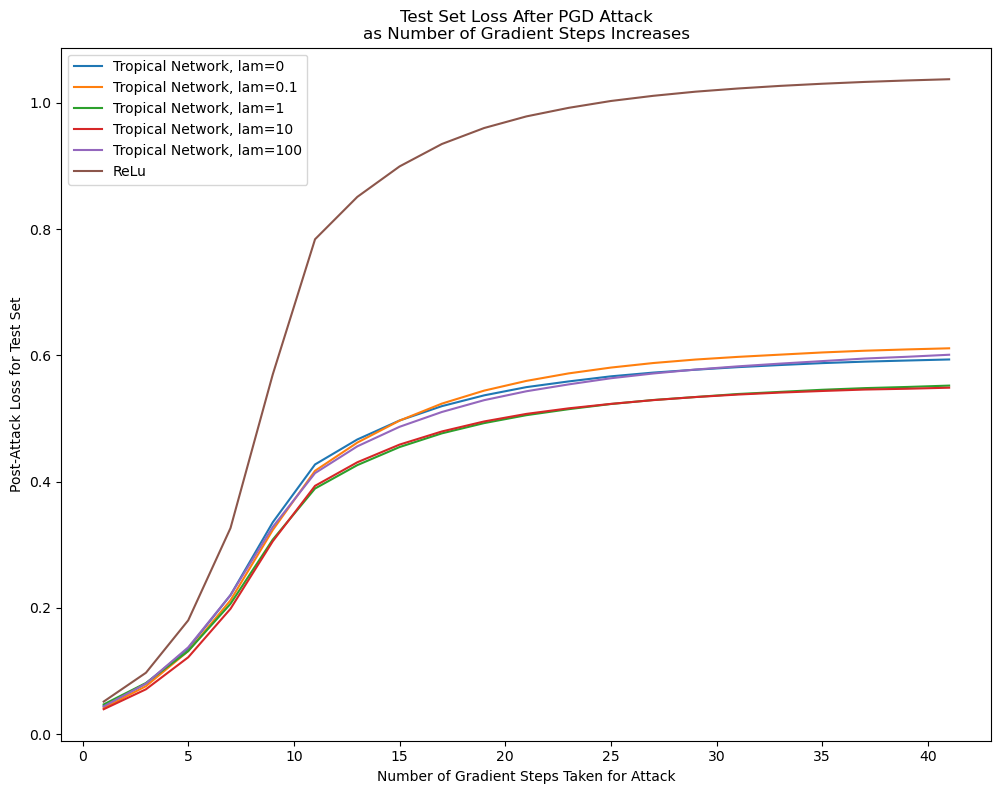

In [5]:
# lambda test plot

import matplotlib.pyplot as plt
import pandas as pd

file_paths=['output_data/lam_test/MNIST_trop_0.csv',
            'output_data/lam_test/MNIST_trop_0.1.csv',
            'output_data/lam_test/MNIST_trop_1.csv',
            'output_data/lam_test/MNIST_trop_10.csv',
            'output_data/lam_test/MNIST_trop_100.csv',
            'output_data/lam_test/MNIST_relu.csv']
labels = ['Tropical Network, lam=0',
          'Tropical Network, lam=0.1',
          'Tropical Network, lam=1',
          'Tropical Network, lam=10',
          'Tropical Network, lam=100',
          'ReLu']
all_data = [pd.read_csv(i) for i in file_paths]
i = 0
plt.figure(figsize=(12, 9))
for df in all_data:
    plt.plot(df['attack'], df['maintained_correct_pred'], label=f"{labels[i]}, Pre-Attack Accuracy: {round(df['pre_acc'].iloc[0],3)}")
    plt.title('Test Set Accuracy Maintained After PGD Attack\nas Number of Gradient Steps Increases')
    plt.xlabel('Number of Gradient Steps Taken for Attack')
    plt.ylabel('Accuracy Maintained After Attack')
    plt.legend()
    i+=1 
plt.show()

i = 0
plt.figure(figsize=(12, 9))
for df in all_data:
    plt.plot(df['attack'], df['post_loss'], label=labels[i])
    plt.title('Test Set Loss After PGD Attack\nas Number of Gradient Steps Increases')
    plt.xlabel('Number of Gradient Steps Taken for Attack')
    plt.ylabel('Post-Attack Loss for Test Set')
    plt.legend()
    i+= 1
plt.show()

